# Predicting stellar mass


The goal of this project is to build a multiple regression model to predict the mass of the stars in planetary systems. NASA's API provides the data describing over 4000 planetary systems discovered in the past 30 years during various exoplant-hunting missions. Using the information about the stars and their planets, can we predict the mass of the star and with what accuracy?

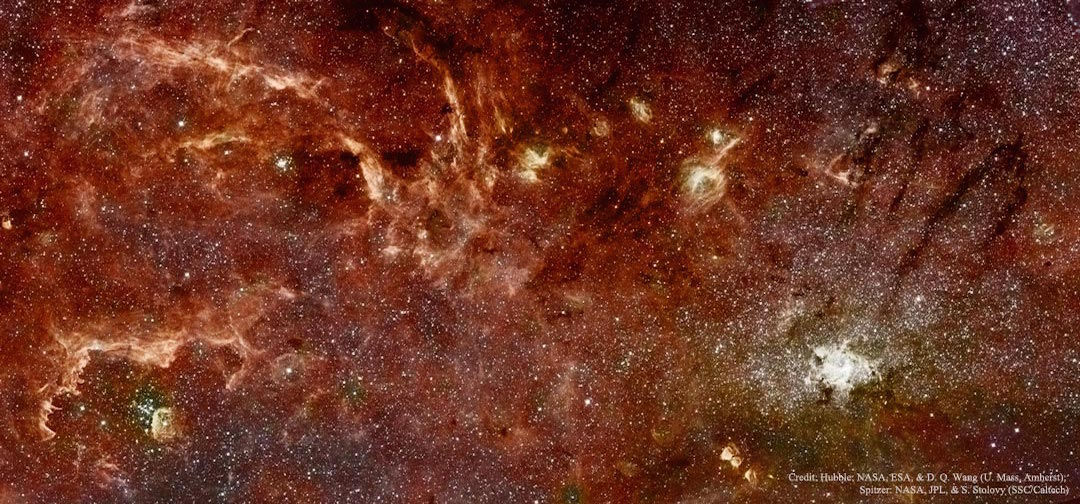

In [89]:
#importing
import pandas as pd
import numpy as np
import helpf as hf
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

%matplotlib inline

# EDA

In [70]:
#after obtaining the data and saving it locally we can take a look at it
#df = pd.read_csv('../Data/planets_table.csv')
df = pd.read_csv('/Users/flatironschool/Documents/flatiron/Mod4_project/Data/planets_table_.csv')
df.head()


,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,...,st_mass,st_masserr1,st_masserr2,st_masslim,st_rad,st_raderr1,st_raderr2,st_radlim,rowupdate,pl_facility
0,b,11 Com b,Radial Velocity,0,1,326.03000,0.32,-0.32,0.0,1.29,...,2.70,0.30,-0.30,0.0,19.00,2.00,-2.00,0.0,2014-05-14,Xinglong Station
1,b,11 UMi b,Radial Velocity,0,1,516.21997,3.20,-3.20,0.0,1.53,...,2.78,0.69,-0.69,0.0,29.79,2.84,-2.84,0.0,2018-09-06,Thueringer Landessternwarte Tautenburg
2,b,14 And b,Radial Velocity,0,1,185.84000,0.23,-0.23,0.0,0.83,...,2.20,0.10,-0.20,0.0,11.00,1.00,-1.00,0.0,2014-05-14,Okayama Astrophysical Observatory
3,b,14 Her b,Radial Velocity,0,1,1773.40002,2.50,-2.50,0.0,2.93,...,0.90,0.04,-0.04,0.0,0.93,0.01,-0.01,0.0,2018-09-06,W. M. Keck Observatory
4,b,16 Cyg B b,Radial Velocity,0,1,798.50000,1.00,-1.00,0.0,1.66,...,1.08,0.04,-0.04,0.0,1.13,0.01,-0.01,0.0,2018-09-06,Multiple Observatories


pl_discmethod
Astrometry                          1
Disk Kinematics                     1
Eclipse Timing Variations          16
Imaging                            47
Microlensing                       86
Orbital Brightness Modulation       6
Pulsar Timing                       7
Pulsation Timing Variations         2
Radial Velocity                   782
Transit                          3135
Transit Timing Variations          21
Name: pl_name, dtype: int64


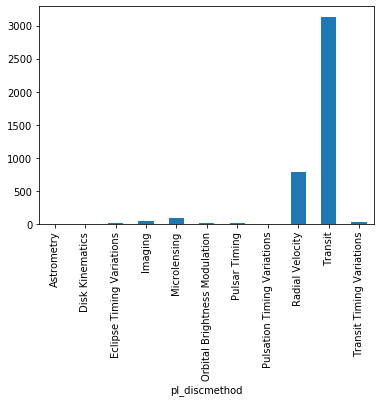

In [71]:
#Which discovery methods are used by NASA astronomers and which one is the most popular?
dicmethod = df.groupby('pl_discmethod')['pl_name'].count()
print(dicmethod)
dicmethod.plot.bar();

pl_pnum
1    2357
2     930
3     429
4     232
5     105
6      36
7       7
8       8
Name: pl_name, dtype: int64


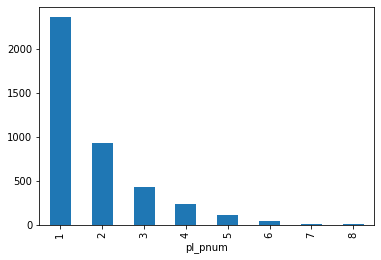

In [72]:
#Knowing that some stars host more than one planet, what does the distribution looks like?
num_planets = df.groupby('pl_pnum')['pl_name'].count()
print(num_planets)
num_planets.plot.bar();

In [73]:
#How many planets have been discovered yet?
df.shape

(4104, 71)

In [74]:
#checking for datatypes and null values
df.dtypes
df.isnull().sum()

pl_letter           0
pl_name             0
pl_discmethod       0
pl_controvflag      0
pl_pnum             0
                 ... 
st_raderr1        486
st_raderr2        511
st_radlim         204
rowupdate           0
pl_facility         0
Length: 71, dtype: int64

# Cleaning the data

As we have seen above, there are a lot of missing values and redundant information. For example, the column 'st_mass' describes the mass of the star and 'st_masserr1' and 'st_masserr2' describe the +- error. This information is important, but we cannot use it in our model. Also, some transformations needed to normalize the data require full information in a row, so we cannot have the missing values (NaNs).

In [75]:
#create a new dataframe 'star-planet-df' and check how many NaNs in each column do we have 
spdf = df[['pl_orbper', 'pl_orbeccen', 'pl_bmassj', 'pl_radj', 'st_optmag', 'st_mass', 'st_teff', 'st_rad', 'pl_pnum']]
spdf.isna().sum()

pl_orbper       118
pl_orbeccen    2679
pl_bmassj      2448
pl_radj         946
st_optmag       200
st_mass         766
st_teff         232
st_rad          359
pl_pnum           0
dtype: int64

In [76]:
#we will lose half of the values, but 2000 exoplanets is still a big dataset. We drop NaNs and create a full dataframe
spdf_full = spdf.dropna()
spdf_full.head()

,pl_orbper,pl_orbeccen,pl_bmassj,pl_radj,st_optmag,st_mass,st_teff,st_rad,pl_pnum
49,41.685500,0.00,0.070,0.23,11.038,1.67,5766.0,1.08,1
65,1.508956,0.00,1.030,1.49,13.600,0.95,5950.0,1.11,1
66,13.240600,0.53,2.750,0.97,15.220,0.89,5075.0,0.79,1
67,2.994330,0.00,2.330,1.43,12.939,1.27,6440.0,1.37,1
68,2.828042,0.07,0.917,1.44,15.515,1.08,5675.0,1.12,1


In [77]:
#Normalize the data by applying the log-transformation to all of our columns
spdf_full_log = spdf_full.apply(np.log)
spdf_full_log.head()

,pl_orbper,pl_orbeccen,pl_bmassj,pl_radj,st_optmag,st_mass,st_teff,st_rad,pl_pnum
49,3.730153,-inf,-2.659260,-1.469676,2.401344,0.512824,8.659734,0.076961,0.0
65,0.411418,-inf,0.029559,0.398776,2.610070,-0.051293,8.691146,0.104360,0.0
66,2.583288,-0.634878,1.011601,-0.030459,2.722610,-0.116534,8.532082,-0.235722,0.0
67,1.096721,-inf,0.845868,0.357674,2.560246,0.239017,8.770284,0.314811,0.0
68,1.039585,-2.659260,-0.086648,0.364643,2.741807,0.076961,8.643826,0.113329,0.0


In [78]:
#Handle the -infinity values that appeared after applying the log-transformation
spdf_full_log['pl_orbeccen'].replace(np.NINF, 0, inplace=True)

# Analysis and Modeling

Before building the model we need to check the assumptions for linear regression:

-Linearity

-Normality (Q-Q plot)

-Homoscedasticity

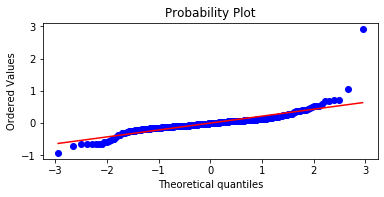

In [79]:
#temperature/mass
hf.qqplot('st_teff','st_mass', spdf_full_log) 

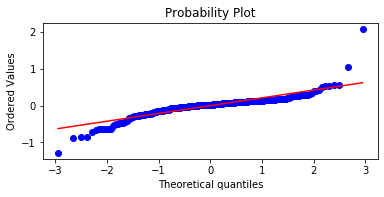

In [80]:
#radius/mass
hf.qqplot('st_rad','st_mass', spdf_full_log) 

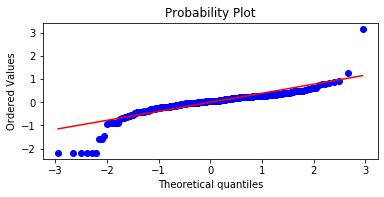

In [81]:
#luminocity/mass
hf.qqplot('st_optmag','st_mass', spdf_full_log) 

Positive correlation
Pearsons correlation: 0.834
LinregressResult(slope=1.94529090068584, intercept=-0.4387606981020904, rvalue=0.8335383150142254, pvalue=7.136850948969941e-113, stderr=0.06217658969986596)


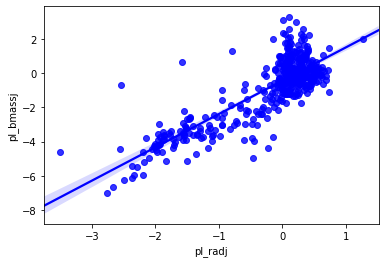

In [82]:
#Do bigger planets have higher mass? (testing the function)
hf.regression(spdf_full_log['pl_radj'], spdf_full_log['pl_bmassj'], 'blue')

Negative correlation
Pearsons correlation: -0.328
LinregressResult(slope=-0.8553824078700721, intercept=2.1582061053877224, rvalue=-0.3275926976881695, pvalue=2.894264212585001e-12, stderr=0.11897083563329572)


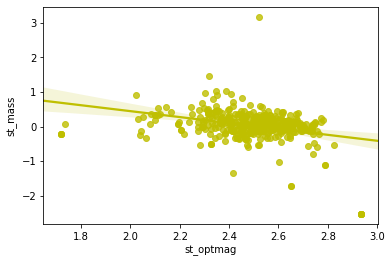

In [83]:
#Can we predict mass of the star by its optical magnitude?
hf.regression(spdf_full_log['st_optmag'], spdf_full_log['st_mass'], 'y')

Positive correlation
Pearsons correlation: 0.529
LinregressResult(slope=0.3039822141124503, intercept=0.09397998978651634, rvalue=0.5294458160662132, pvalue=1.394732279973759e-32, stderr=0.02348898729722187)


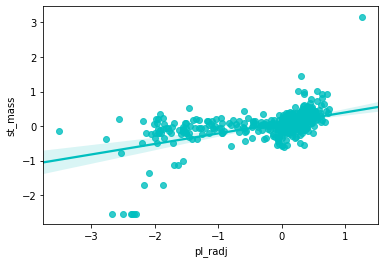

In [84]:
#How does the mass-radius relationship look like?
hf.regression(spdf_full_log['pl_radj'], spdf_full_log['st_mass'], 'c')

Positive correlation
Pearsons correlation: 0.095
LinregressResult(slope=0.31787200418319933, intercept=-1.4679422459622122, rvalue=0.09451683304642515, pvalue=0.049622886274208355, stderr=0.16145827346965694)


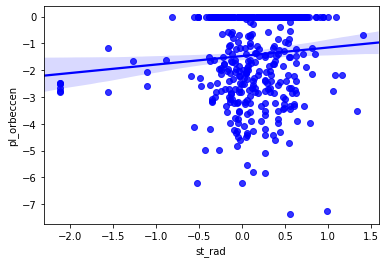

In [85]:
#Is there any correlation at all between the mass of the star and the eccentricity of the planets?
hf.regression(spdf_full_log['st_rad'], spdf_full_log['pl_orbeccen'], 'b')

Let's try to build our first multiple regression model:

Dependent Variable ($y$): Stellar mass ('st_mass')


Independent variables ($x$): Planetary orbital period ('pl_orbper'), eccentricity ('pl_orbeccen'), planetary mass ('pl_bmassj), planetary radius ('pl_radj'), number of planets in the system ('pl_pnum').

In [86]:
model = ols(formula="st_mass~pl_pnum+pl_orbper+pl_orbeccen+pl_bmassj+pl_radj", data=spdf_full_log).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                st_mass   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     36.91
Date:                Thu, 16 Jan 2020   Prob (F-statistic):           2.02e-31
Time:                        14:40:55   Log-Likelihood:                -204.96
No. Observations:                 432   AIC:                             421.9
Df Residuals:                     426   BIC:                             446.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0512      0.034      1.484      0.139      -0.017       0.119
pl_pnum         0.0006      0.056      0.010      0.992      -0.110       0.111
pl_orbper       0.0500      0.017      3.016      0.003       0.017       0.083
pl_orbeccen     0.0153      0.013      1.213      0.226      -0.009       0.040
pl_bmassj       0.0391      0.019      2.044      0.042       0.002       0.077
pl_radj         0.2440      0.044      5.568      0.000       0.158       0.330
==============================================================================
Omnibus:                      103.962   Durbin-Watson:                   1.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1952.067
Skew:                          -0.460   Prob(JB):                         0.00
Kurtosis:                      13.373   Cond. No.                         9.89
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Remove number of planets in the system ('pl_pnum') since it is not contributing.

Dependent Variable ( yy ): Stellar mass ('st_mass')

Independent variables ( xx ): Planetary orbital period ('pl_orbper'), eccentricity ('pl_orbeccen'), planetary mass ('pl_bmassj), planetary radius ('pl_radj').

In [87]:
model = ols(formula="st_mass~pl_orbper+pl_orbeccen+pl_bmassj+pl_radj", data=spdf_full_log).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                st_mass   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     46.25
Date:                Thu, 16 Jan 2020   Prob (F-statistic):           2.78e-32
Time:                        14:40:57   Log-Likelihood:                -204.96
No. Observations:                 432   AIC:                             419.9
Df Residuals:                     427   BIC:                             440.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0512      0.034      1.486      0.138      -0.017       0.119
pl_orbper       0.0500      0.016      3.057      0.002       0.018       0.082
pl_orbeccen     0.0153      0.012      1.232      0.219      -0.009       0.040
pl_bmassj       0.0390      0.018      2.149      0.032       0.003       0.075
pl_radj         0.2439      0.042      5.795      0.000       0.161       0.327
==============================================================================
Omnibus:                      103.898   Durbin-Watson:                   1.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1950.814
Skew:                          -0.460   Prob(JB):                         0.00
Kurtosis:                      13.370   Cond. No.                         7.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dependent Variable ($y$): Stellar mass ('st_mass')


Independent variables ($x$): Planetary orbital period ('pl_orbper'), eccentricity ('pl_orbeccen'), planetary mass ('pl_bmassj), planetary radius ('pl_radj'), stellar optical magnitude ('st_optmag'), stellar tempereture ('st_teff'),
stellar radius ('st_rad').

In [88]:
model = ols(formula="st_mass~st_rad+st_teff+st_optmag+pl_orbper+pl_orbeccen+pl_bmassj+pl_radj", data=spdf_full_log).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                st_mass   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     240.1
Date:                Thu, 16 Jan 2020   Prob (F-statistic):          3.45e-143
Time:                        14:41:14   Log-Likelihood:                 63.394
No. Observations:                 432   AIC:                            -110.8
Df Residuals:                     424   BIC:                            -78.24
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -8.7336      1.090     -8.013      0.000     -10.876      -6.591
st_rad          0.4862      0.042     11.446      0.000       0.403       0.570
st_teff         1.0682      0.123      8.690      0.000       0.827       1.310
st_optmag      -0.1985      0.063     -3.134      0.002      -0.323      -0.074
pl_orbper      -0.0042      0.009     -0.465      0.642      -0.022       0.014
pl_orbeccen    -0.0048      0.007     -0.713      0.476      -0.018       0.008
pl_bmassj       0.0155      0.010      1.579      0.115      -0.004       0.035
pl_radj         0.0138      0.024      0.565      0.572      -0.034       0.062
==============================================================================
Omnibus:                      369.080   Durbin-Watson:                   1.615
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29428.348
Skew:                           3.079   Prob(JB):                         0.00
Kurtosis:                      42.962   Cond. No.                     1.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Try predicting the stellar mass using only the information about the star (radius, temperature, luminocity)

In [68]:
model = ols(formula="st_mass~st_rad+st_teff+st_optmag", data=spdf_full_log).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                st_mass   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     547.1
Date:                Thu, 16 Jan 2020   Prob (F-statistic):          5.16e-146
Time:                        14:39:17   Log-Likelihood:                 57.680
No. Observations:                 432   AIC:                            -107.4
Df Residuals:                     428   BIC:                            -91.09
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.6005      1.060     -9.059      0.000     -11.684      -7.518
st_rad         0.5070      0.041     12.257      0.000       0.426       0.588
st_teff        1.1529      0.121      9.555      0.000       0.916       1.390
st_optmag     -0.1516      0.060     -2.511      0.012      -0.270      -0.033
==============================================================================
Omnibus:                      378.256   Durbin-Watson:                   1.610
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30372.735
Skew:                           3.209   Prob(JB):                         0.00
Kurtosis:                      43.573   Cond. No.                         942.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Train-test split and regularization (Ridge, Lasso):

In [34]:
X = spdf_full_log[['st_rad', 'st_teff', 'st_optmag']]
y = spdf_full_log['st_mass']

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

hf.split_test(X, y, 0.2)

training set has 345 observations
testing set has 87 observations


Train Error Ridge Model 16.779723500473718
Test Error Ridge Model 2.7235544532921585


Train Error Lasso Model 86.02316593557262
Test Error Lasso Model 7.784583915816854


Train Error Unpenalized Linear Model 16.71368564252154
Test Error Unpenalized Linear Model 2.694429205266254


Cross-validation with Ridge:

In [36]:
hf.cross_validation(X,y)

Test r2: [0.5323353006847897, 0.5806070335026066, 0.8296427209000213]
Train r2: [0.8618898442856091, 0.802974700404789, 0.6532978926104681]
Test MSE: [-0.06964767041599834, -0.03677174463642955, -0.06737738844812087]
Train MSE: [-0.0335912013047168, -0.05540259972384417, -0.04204210583791909]


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


To improve the model, we include the polynomial terms:

In [37]:
spdf_full_log['st_rad_p'] = spdf_full_log['st_rad']**2
spdf_full_log['temp_p'] = spdf_full_log['st_teff']**2
spdf_full_log['optmag_p'] = spdf_full_log['st_optmag']**2

In [38]:
model = ols(formula="st_mass~st_rad_p+temp_p+optmag_p", data=spdf_full_log).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                st_mass   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     373.5
Date:                Thu, 16 Jan 2020   Prob (F-statistic):          4.30e-119
Time:                        14:30:05   Log-Likelihood:                -4.9331
No. Observations:                 432   AIC:                             17.87
Df Residuals:                     428   BIC:                             34.14
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.2660      0.434    -21.348      0.000     -10.119      -8.413
st_rad_p      -0.0891      0.024     -3.663      0.000      -0.137      -0.041
temp_p         0.1290      0.005     23.933      0.000       0.118       0.140
optmag_p      -0.0470      0.015     -3.211      0.001      -0.076      -0.018
==============================================================================
Omnibus:                      489.188   Durbin-Watson:                   1.519
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63727.301
Skew:                           4.824   Prob(JB):                         0.00
Kurtosis:                      61.714   Cond. No.                     2.74e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Squaring the terms didn't improve the $R^2$, so we try again:

In [45]:
spdf_full_log['st_rad_p'] = spdf_full_log['st_rad']**3
spdf_full_log['temp_p'] = spdf_full_log['st_teff']**5
spdf_full_log['optmag_p'] = spdf_full_log['st_optmag']**5

In [46]:
model = ols(formula="st_mass~st_rad_p+temp_p+optmag_p", data=spdf_full_log).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                st_mass   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     562.8
Date:                Thu, 16 Jan 2020   Prob (F-statistic):          4.18e-148
Time:                        11:20:08   Log-Likelihood:                 62.544
No. Observations:                 432   AIC:                            -117.1
Df Residuals:                     428   BIC:                            -100.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9080      0.162    -17.978      0.000      -3.226      -2.590
st_rad_p       0.1654      0.011     14.544      0.000       0.143       0.188
temp_p      6.233e-05   3.16e-06     19.706      0.000    5.61e-05    6.85e-05
optmag_p      -0.0004      0.000     -1.151      0.250      -0.001       0.000
==============================================================================
Omnibus:                      480.656   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56476.766
Skew:                           4.715   Prob(JB):                         0.00
Kurtosis:                      58.215   Cond. No.                     7.70e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
X = spdf_full_log[['st_rad_p', 'temp_p', 'optmag_p']]
y = spdf_full_log['st_mass']

hf.split_test(X, y, 0.2)

training set has 345 observations
testing set has 87 observations


Train Error Ridge Model 23.64854987484918
Test Error Ridge Model 2.3423255056958663


Train Error Lasso Model 37.38904970345433
Test Error Lasso Model 7.791887611652011


Train Error Unpenalized Linear Model 23.64854162051327
Test Error Unpenalized Linear Model 2.3407531844292926


In [40]:
hf.cross_validation(X,y)

Test r2: [0.2657174454547053, 0.6764013663058852, 0.07878835222407554]
Train r2: [0.8422827686280724, 0.7257303526637479, 0.6515377585575384]
Test MSE: [-0.10935413647015178, -0.028372641587854217, -0.36434507150531104]
Train MSE: [-0.038360041235439596, -0.07712335176745813, -0.04225554481208448]


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


We managed to build a model that predicts stellar mass from its temperature, optical magnitude, and radius with $R^2=0.796$ and sufficiently small mean squared error on both train and test data sets.